# Example Usage

This notebook demonstrates how one can use the implementation to compute core and alpha-core persistent homology of point clouds.

In [1]:
import gudhi
import numpy as np
import math
import matplotlib.pyplot as plt
from miniball import Miniball
import warnings
warnings.filterwarnings('ignore')

from core import core_alpha, sqrt_persistence, persistence_intervals_in_dimension
from datasets import sample_circle, sample_rectangle, sample_torus, sample_cube, sample_flat_torus, sample_sphere

In [2]:
rng = np.random.default_rng(seed=0)

In [3]:
def plot_point_cloud(X):
    fig = plt.figure()

    if X.shape[-1] == 2:
        ax = fig.add_subplot()
        ax.scatter(*X.T, s=10, color="black", alpha=0.5, edgecolor="none")
    elif X.shape[-1] == 3:
        ax = fig.add_subplot(projection="3d")
        ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
        
    else:
        raise ValueError(f"Point cloud must be of dimension 2 or 3, not {X.shape[-1]}.")

    ax.set_aspect("equal")
    ax.axis("off")
    plt.show()

In [4]:
def embedded_torus(M, N, sigma, rng=None, seed=0):
    if rng is None:
        rng = np.random.default_rng(seed=seed)
    Z = sample_torus(N, rng, a=1, b=3, std=sigma)
    upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
    Y = sample_rectangle(M, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
    return np.r_[Z, Y]

In [34]:
M = 1000
N = 10000
sigma = 0.07
X_clean = embedded_torus(0, M + N, 0, rng)
X_noisy = embedded_torus(M, N, sigma, rng)

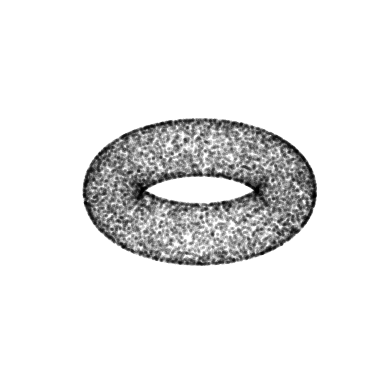

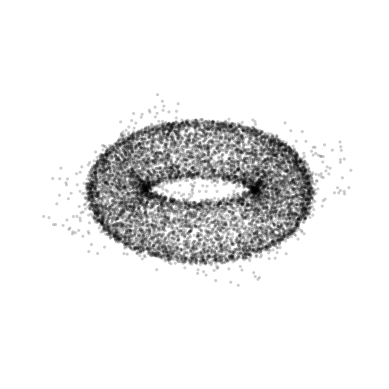

In [35]:
plot_point_cloud(X_clean)
plot_point_cloud(X_noisy)

In [36]:
def alpha_core_presistence(X, max_s, beta):
    max_r = 2*math.sqrt(Miniball(X).squared_radius())
    max_k = max(1, int((M + N) * max_s))
    st = core_alpha(X, max_k=max_k, max_r=max_r, beta=beta)
    persistence = sqrt_persistence(st)
    return persistence

def bottleneck_distances(pers_clean, pers_noisy, dim):
    n = len(pers_noisy)
    A = np.zeros(n)
    for i in range(n):
        a = persistence_intervals_in_dimension(pers_clean, dim)
        b = persistence_intervals_in_dimension(pers_noisy[i], dim)
        bdist = gudhi.bottleneck_distance(a, b)
        A[i] = bdist
    return A

using betas [0.125, 0.25, 0.5, 1, 2, 4, 8, 16]


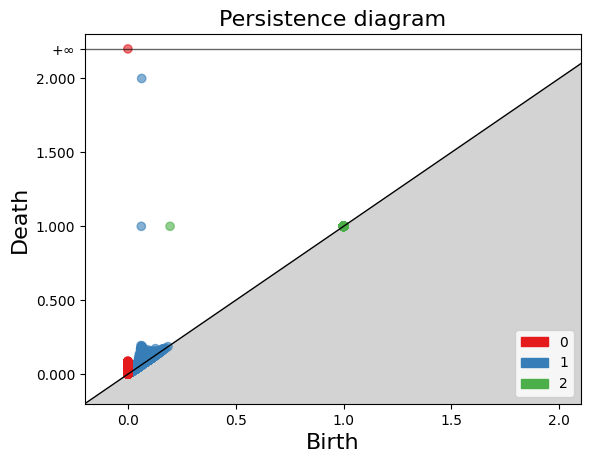

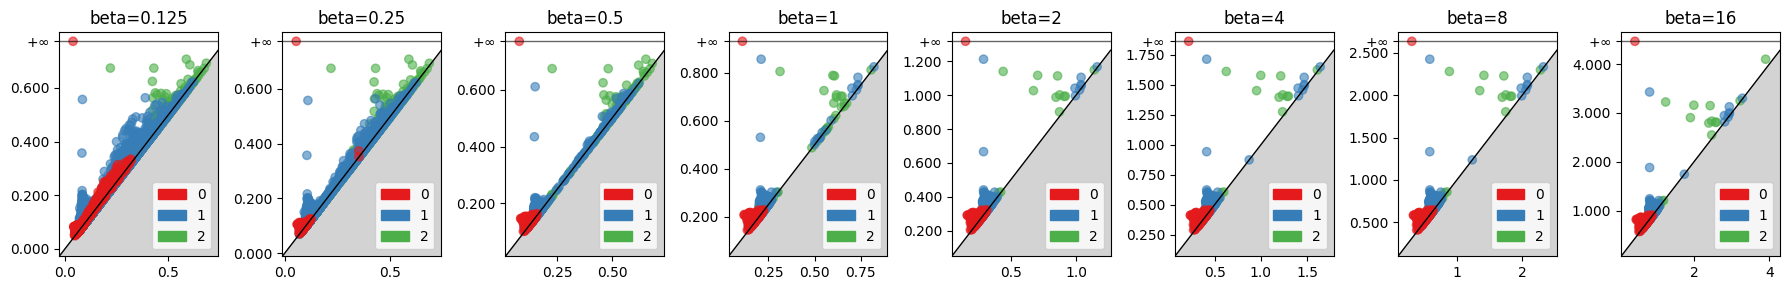

In [37]:
max_s = 0.001
betas = [2 ** i for i in range(-3, 5)]
print(f"using betas {betas}")

persistence_clean = alpha_core_presistence(X_clean, 0, beta=1)
gudhi.plot_persistence_diagram(persistence_clean)
plt.show()

persistence_noisy = []

fig, ax = plt.subplots(ncols=len(betas), nrows=1, figsize=(18, 3))

for i, beta in enumerate(betas):
    diag = alpha_core_presistence(X_noisy, max_s, beta=beta)
    persistence_noisy.append(diag)
    gudhi.plot_persistence_diagram(diag, axes=ax[i])
    ax[i].set_title(f"beta={beta}")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

fig.tight_layout()
plt.show()

[0.04280451 0.05453825 0.07712873 0.10907649 0.15425746 0.21815299
 0.30851491 0.43630597]
[0.96809815 0.96809815 0.96809815 0.96809815 0.78751801 0.35091715
 0.52027557 1.30170306]
[0.32576005 0.32576005 0.32576005 0.19387533 0.24687012 0.49338394
 0.69775025 0.98676787]


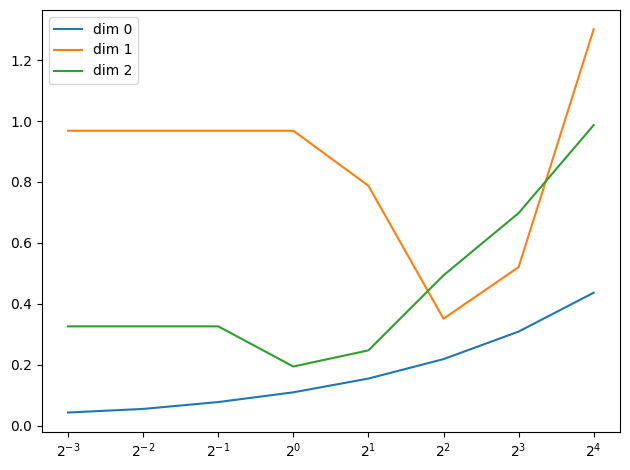

In [38]:
for dim in [0, 1, 2]:
    dists = bottleneck_distances(persistence_clean, persistence_noisy, dim)
    print(dists)
    plt.plot(betas, dists, label=f"dim {dim}")
plt.xticks(betas, betas)
plt.xscale("log", base=2)
plt.legend()
plt.tight_layout()
plt.show()